In [1]:
#JV

I would develop the code for the assignment in this notebook as it is easy to quickly test (and even unit testing).

When a module/part is bug free I would add it to the .py file later.



In [2]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import wandb

import torch.optim as optims
from torch.utils.data import Dataset, DataLoader,ChainDataset, ConcatDataset
from torch.utils.data.distributed import DistributedSampler

import matplotlib.pyplot as plt

In [4]:
seed = 76 #setting this as seed wherever randomness comes

In [19]:
class DataPreparation:

    def __init__(self,data_dir,device,default_transforms=None):

        self.base_dir  = data_dir
        self.device = device
        self.default_transforms = default_transforms

    
    def create_dataloader(self,sub_dir,batch_size=16,shuffle=True,num_workers=2,data_augmentation_transforms = None,pin_memory = False):

        """
        Method to create dataset and return dataloader after applying all necessary transforms.

        params:

            sub_dir : "train/" or "validation/" or "test/"
            batch_size : The batch size in which training has to be performed.
            shuffle : whether shuffling must be done before sampling.
            num_works : Number of workers to be used on the dataset.
            data_augmentation_transforms : Either None or List of List of transforms, with each sub-list leading to a dataset.

        Returns:

            Dataloader corresponding to the dataset.
        
        """

        print(f"Preparing data from {sub_dir}")

        
        ## The most basic list of transforms applied to the orignal train dataset and validation and test dataset.
        vanilla_transforms = [self.default_transforms]

        if ("train" in sub_dir) and (data_augmentation_transforms): ## if data augmentation is to be done
            
            original_dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=transforms.Compose(vanilla_transforms))

            dataset_list = [original_dataset]
            
            for aug_transform in data_augmentation_transforms:
                
                cur_data_transforms_list = [self.default_transforms] + aug_transform 
                cur_dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=transforms.Compose(cur_data_transforms_list))
                dataset_list.append(cur_dataset)

            self.dataset = ConcatDataset(dataset_list)
        else:

            self.dataset = torchvision.datasets.ImageFolder(root=self.base_dir+sub_dir,transform=transforms.Compose(vanilla_transforms))

        
        
        ## Now create the data loader
        
        sampler = None ## unless the dataloading is distributed across devices or processes.
        
        if "train" in sub_dir:

            #torch.distributed.init_process_group(rank=0,world_size = 4)

            #sampler = DistributedSampler(self.dataset)

            self.loader = torch.utils.data.DataLoader(dataset=self.dataset,batch_size=batch_size,shuffle=shuffle,num_workers=num_workers,pin_memory = pin_memory,sampler=sampler)

        else:

            num_workers = 3
            pin_memory = False

            self.loader = torch.utils.data.DataLoader(self.dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory = pin_memory,sampler=sampler)
            
        return self.loader
        

In [24]:
class Experiment:

    """
    Class to create and conduct experiments
    """
    
    def __init__(self,device,base_dir,wandb_logging=False,on_kaggle = False):

        self.device = device
        self.base_data_dir = base_dir
        self.wandb_logging = wandb_logging
        self.on_kaggle = on_kaggle

    def create_dataloaders(self,batch_size,shuffle,list_of_train_data_augmentation_transforms,num_workers=0,pin_memory=False):

        """
        Method to create dataloaders for train,test and validation datasets, with the help from the DataPreparation class.

        params:

            batch_size : The training batch size (also applied to test and validation loaders, but anyway its still the same).
            shuffle : True/False, whether to shuffle data before sampling.
            list_of_train_data_augmentation_transforms : None, if no data augmentation or List of List of transforms, with each sub-list leading to a dataset.
            num_workers : Number of workers to support the dataloader, default is 0.
            pin_memory : Default is False. Pinning memory makes data loading efficent when a accelerator is used and num of workers>0.

        Returns:

            Torch dataloader objects for training,testing and validation data.
        
        """
        ## Create an object of the data preparation class
        dataprep = DataPreparation(data_dir=self.base_data_dir,device = self.device,default_transforms = self.default_transforms)

        if (not self.device == "cpu") and num_workers>0:
            pin_memory = True

        ## create a train dataset loader
        self.train_loader = dataprep.create_dataloader(sub_dir = "train/",batch_size = batch_size,shuffle = shuffle, num_workers = num_workers,data_augmentation_transforms = list_of_train_data_augmentation_transforms,pin_memory=pin_memory)

        ## it is not efficient to pin memory for validation and test datasets,as they are relatively small.
        self.val_loader = dataprep.create_dataloader(sub_dir = "validation/",batch_size = batch_size,shuffle = shuffle, num_workers = num_workers,pin_memory=False)
        self.test_loader = dataprep.create_dataloader(sub_dir = "test/",batch_size = batch_size,shuffle = shuffle, num_workers = num_workers,pin_memory=False)

        return self.train_loader,self.val_loader,self.test_loader


    def createResNet(self,num_output_neurons):

        """
        Method to Create the ResNet architecture with the pre-trained weights. Making suitable for finetuning.

        Params:

            num_output_neurons: Number of neurons in the output layer.

            
        Returns:
        
            None.
            
        """
        
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2) ##using weights of IMAGENET1K_V2, which gave an accuracy of 80%

        weights = ResNet50_Weights.IMAGENET1K_V2
        self.default_transforms = weights.transforms() ## these are the transforms to be applied on the input images before feeding to the model
        
        # Freeze all layers except the last layer
        for param in self.model.parameters():
            param.requires_grad = False
        
        ## Now the output layer of ResNet50 model simply passes through the output of the penultimate hidden layer.
        ## last fully connected layer of resnet can be accessed using model.fc
        
        resnet_last_fc_size = self.model.fc.in_features ## first store the output size.
        self.model.fc = nn.Identity() 
        
        ## now add an output layer with 10 neurons to ResNet50 model
        self.model.fc = nn.Linear(resnet_last_fc_size, out_features=num_output_neurons)
        
        ## Initializae weights and biases of this layer. Using xavier initialization for weights
        torch.nn.init.xavier_uniform_(self.model.fc.weight)
        self.model.fc.bias.data.fill_(0.01)
        
        # Make the weights of the last layer trainable
        for param in self.model.fc.parameters():
            param.requires_grad = True
        
        ## Use LogSoftmax activation for the output layer
        #model.fc = nn.LogSoftmax(model.fc)
        
        self.model.to(self.device) ## move the model to the device


    def compute_accuracy(self,model,data_iterator):

        """
        Method to compute the accuracy of the given model over the dataset in the data_iterator.

        params:

            model : The torch neural net model whose performance has to be measured.

            data_iterator : The data iterator over which the computation of the metrics has to be done.

        Returns:

            loss,accuracy of the "model" over the "data_iterator".
        """
    
        correct_preds = 0
        total_preds = 0
    
        loss = 0
        train_mode = model.training
        
        # since we're testing, switch of train mode if it is on.
        if train_mode:
            model.eval()
    
        with torch.no_grad(): ##don't compute gradients
            for data in data_iterator:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device) ## move the inputs and labels to the device
        
                # calculate outputs by running images through the network
                outputs = model(images)
                loss += self.criterion(outputs, labels).item() * images.size(0) ## loss.item() is average loss of the batch, so multiply by batch size.
                
                preds = torch.max(outputs.data, 1)[1]
                
                total_preds += images.size(0)
                correct_preds += (preds == labels).sum().item()
        
        if train_mode: # if model was originally in train mode, switch it back to train mode.
            model.train() ## switch back to train mode
    
        #print(f'Accuracy of the model on the {len(data_iterator.dataset.samples)} test images: {round(100*correct/total,2)} %')
    
        accuracy = round(100*correct_preds/total_preds,2)
        loss = round(loss/total_preds,2)
        
        return loss,accuracy

    def train(self,lr,weight_decay,loss,optimiser,epochs):

        """
        The method to perform the training, assuming model is already created using createCNNmodel method.

        Params:

            lr : Learning rate
            weight_decay : l2 regularization parameter.
            loss : string, loss type. currently only "crossentropy" is supported
            optimiser : "adam","nadam","rmsprop".
            epochs : number of epochs to train.
            
        Returns:

            None.
        """

        ## specify the optimiser
        if optimiser.lower() == "adam":
            self.optimiser = optim.Adam(self.model.parameters(), lr=lr,weight_decay=weight_decay)

        elif optimiser.lower() == "nadam":
            self.optimiser = optim.NAdam(self.model.parameters(), lr=lr,weight_decay=weight_decay)

        elif optimiser.lower() == "rmsprop":
            self.optimiser = optim.RMSprop(self.model.parameters(), lr=lr,weight_decay=weight_decay)

        ## Specify the loss criteria
        if loss.lower() == "crossentropy":
            self.criterion = nn.CrossEntropyLoss().to(self.device)

        

        start_time = time.time()

        ## loop over the dataset multiple times
        for epoch in tqdm(range(epochs)):  
            
            correct_preds = 0
            total = 0
            count = 0
            epoch_loss = 0.0
        
            
            for i, data in enumerate(self.train_loader):
                
                ## i is batch index
                
                images, labels = data[0].to(self.device),data[1].to(self.device)  ## move the images and labels to the device.
        
                
                # zero the parameter gradients
                self.optimiser.zero_grad()
            
                # forward + backward + optimize
                # logsoftmax is the output activation
                outputs = F.log_softmax(self.model(images).to(self.device),dim=1)
                
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimiser.step()
            
                epoch_loss +=  loss.item() * images.size(0) ## loss.item() is average loss of the batch, so multiply by batch size.
                
                preds = torch.max(outputs.data, 1)[1]
                
                total += images.size(0)
                correct_preds += (preds == labels).sum().item()


            train_accuracy = round(100*correct_preds/total,2)
            train_loss = epoch_loss/total
            
            val_loss,val_accuracy = self.compute_accuracy(self.model,self.val_loader)
        
            if epoch%5 == 0:


                if self.on_kaggle:
                    torch.save(self.model, "/kaggle/working/model")
                else:
                    torch.save(self.model, "Model")
                
        
            if epoch == 0:
                print(f"Samples in Train Data : {total}")

            if self.wandb_logging:

                wandb.log({'train loss': train_loss, 'train accuracy': train_accuracy, 'Validation loss': val_loss, 'Validation accuracy': val_accuracy,'epoch': epoch+1})

            print(f'Epoch : {epoch+1}\t Train Accuracy : {train_accuracy:.2f}%\t Train loss: {train_loss:.2f}\t Validation Accuracy : {val_accuracy:.2f}%\t Validation Loss : {val_loss:.2f}')
            epoch_loss = 0.0
        
        print('Finished Training!!')
        
        end_time = time.time() - start_time
        print(f"Time Taken for Training: {round(end_time/60,2)}")

    
        

## Choosing ResNet50 as pre-trained model for finetuning.

Because:

1. The Identity connections used in the architecture is a really cool idea. Wanted to have some hands on on it.
2. It has a really good accuracy on the ImageNet challenge, which means it is good at recognizing many species like shark etc. So hoping it would give a boost now.

### Addressing the issue of input image shape difference between ResNet and the Dataset.


The inference transforms are available at ResNet50_Weights.IMAGENET1K_V2.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[232] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].


Source : [https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


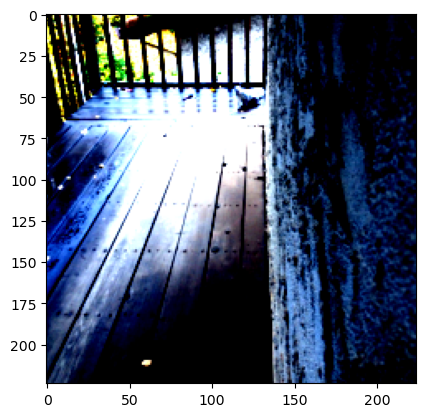

In [36]:
"""
To viz images after transform
"""

#plt.imshow(img[1].permute(1,2,0))
#plt.show()

In [8]:
wandb.login(key="38853ce9d1432bd40bf80d2d27657183fc335aeb")


sweep_config = {
    'method': 'random',
    'name' : 'PA2 Hyper Sweep Factor Two',
    'metric': {
      'name': 'Validation accuracy',
      'goal': 'maximize'
    },
    'parameters': {

        'optimiser': {
            'values': ["adam","rmsprop","nadam"]
        },
        
        'lr': {
            'values': [1e-3,1e-4,3e-4]
        },
        
        'weight_decay': {
            'values': [0,5e-3,5e-4]
        },


        'data_aug' : {

            'values' : [None,1,2]
        },

        'epochs' : {

            'values' : [5]
        },

        'batch_size':{
            'values' : [16,32]
        }
        }

        }
    }

sweep_id = wandb.sweep(sweep=sweep_config, project='JV_CS23M036_TEJASVI_DL_ASSIGNMENT2')

wandb: Currently logged in as: cs23m036 (tmajestical). Use `wandb login --relogin` to force relogin


Create sweep with ID: shrmtcif
Sweep URL: https://wandb.ai/tmajestical/JV_CS23M036_TEJASVI_DL_ASSIGNMENT2/sweeps/shrmtcif


In [12]:
def setup_and_start_expt(config,wandb_log=False,kaggle = False):
    ##using apple silicon GPU

    wandb_logging = wandb_log
    on_kaggle = kaggle

    if on_kaggle:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        base_data_dir = "/kaggle/input/jv-inaturalist-dataset/inaturalist_12K/"
    else:
        device = "mps"
        base_data_dir = "inaturalist_12K/"
        
    
    print(f"Using {device}")

    ## dataloader creation hyperparams:
    
    batch_size = config['batch_size']
    shuffle = True
    num_workers = 2
    pin_memory = False

    #RandomSolarize(threshold=192.0)

    if config['data_aug']:
        
        train_data_augmentation_transforms1 = [transforms.RandomPerspective(p=1)] ## Random perspective transform
        train_data_augmentation_transforms2 = [transforms.ColorJitter(brightness=.5, hue=.5)] ## colour jitter
        #train_data_augmentation_transforms = [transforms.ElasticTransform()] ## this is good, but computationally extremely expensive
        
        list_of_train_data_augmentation_transforms = [train_data_augmentation_transforms1,train_data_augmentation_transforms2]
        list_of_train_data_augmentation_transforms = list_of_train_data_augmentation_transforms[:config['data_aug']]
    
    else: ## if no data augmentation, train_loader returned would just be on the original dataset.
        
        list_of_train_data_augmentation_transforms = []
        

    ## create an experiment
    experiment = Experiment(device=device,base_dir = base_data_dir, wandb_logging=False,on_kaggle = False)

     ## CNN Hyperparams
    num_output_neurons =  10
    
    ## create CNN model
    experiment.createResNet(num_output_neurons)
    
    ##create data loaders for train, validation and test datasets.
    train_loader,val_loader,test_loader  = experiment.create_dataloaders(batch_size=batch_size,shuffle=shuffle,list_of_train_data_augmentation_transforms=list_of_train_data_augmentation_transforms,num_workers=num_workers,pin_memory=pin_memory)
    
    
    ##training Hyper Params:
    
    lr = config['lr']
    weight_decay = config['weight_decay']
    optimiser = config['optimiser']
    epochs = config['epochs']
    loss = "crossentropy"
    
    experiment.train(lr = lr,weight_decay = weight_decay,loss = loss,optimiser = optimiser,epochs = epochs)


In [22]:
custom_config = {

        'optimiser': "adam",
        
        'lr' : 1e-4,
        
        'weight_decay': 0,

        'data_aug' : None,

        'epochs' : 2,

        'batch_size': 16
    }

In [23]:
#setup_and_start_expt(custom_config)

Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/z4/__x0n5jn4f1c4z527hs4r4_00000gn/T/ipykernel_5586/2281458533.py:203: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.log_softmax(self.model(images).to(self.device))


Samples in Train Data : 7999
Epoch : 1	 Train Accuracy : 41.62%	 Train loss: 1.92	 Validation Accuracy : 61.50%	 Validation Loss : 1.62
Epoch : 2	 Train Accuracy : 65.78%	 Train loss: 1.40	 Validation Accuracy : 71.45%	 Validation Loss : 1.28
Finished Training!!
Time Taken for Training: 2.42


In [ ]:
def main():
    '''
    WandB calls main function each time with differnet combination.

    We can retrive the same and use the same values for our hypermeters.

    '''


    with wandb.init() as run:

        run_name="-hl_"+str(wandb.config.num_hidden_layers)+"-hs_"+str(wandb.config.hidden_size)+"-ac_"+str(wandb.config.activation)

        run_name = run_name+"-optim_"+str(wandb.config.optimiser)+"-lr_"+str(wandb.config.lr)+"-reg_"+str(wandb.config.weight_decay)+"-epochs_"+str(wandb.config.epochs)+"-data_aug"+str(wandb.config.data_aug)

        run_name = run_name+"-dropout_"+str(wandb.config.dropout)+"-batch_norm_"+str(wandb.config.batch_norm)+"-conv_filter_factor_"+str(wandb.config.conv_filter_factor)+"-num_filters_"+str(wandb.config.num_filters)+"-filter_size_"+str(wandb.config.filter_size)

        wandb.run.name=run_name

        setup_and_start_expt(wandb.config,wandb_log = True,kaggle = False)


wandb.agent(sweep_id, function=main,count=100) # calls main function for count number of times.
wandb.finish()

wandb: Agent Starting Run: sje1giea with config:
wandb: 	Image_Crop_Size: 600
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: None
wandb: 	dropout: 0.2
wandb: 	epochs: 8
wandb: 	filter_size: 7
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 16
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 7999
Epoch : 1	 Train Accuracy : 15.01%	 Train loss: 2.29	 Validation Accuracy : 17.35%	 Validation Loss : 2.22
Epoch : 2	 Train Accuracy : 20.87%	 Train loss: 2.18	 Validation Accuracy : 23.85%	 Validation Loss : 2.13
Epoch : 3	 Train Accuracy : 25.45%	 Train loss: 2.08	 Validation Accuracy : 26.50%	 Validation Loss : 2.06
Epoch : 4	 Train Accuracy : 32.08%	 Train loss: 1.94	 Validation Accuracy : 28.45%	 Validation Loss : 2.02
Epoch : 5	 Train Accuracy : 37.63%	 Train loss: 1.79	 Validation Accuracy : 30.65%	 Validation Loss : 2.00
Epoch : 6	 Train Accuracy : 44.72%	 Train loss: 1.58	 Validation Accuracy : 29.70%	 Validation Loss : 2.06
Epoch : 7	 Train Accuracy : 53.66%	 Train loss: 1.33	 Validation Accuracy : 28.10%	 Validation Loss : 2.23
Epoch : 8	 Train Accuracy : 62.77%	 Train loss: 1.07	 Validation Accuracy : 27.15%	 Validation Loss : 2.43
Finished Training!!
Time Taken for Training: 16.33


Validation accuracy,▁▄▆▇██▇▆
Validation loss,▅▃▂▁▁▂▅█
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▂▃▄▄▅▇█
train loss,█▇▇▆▅▄▃▁
Validation accuracy,27.15
Validation loss,2.43
epoch,8
train accuracy,62.77
train loss,1.06882


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mp8y7y88 with config:
wandb: 	Image_Crop_Size: 500
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 2
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.0003
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 16
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 24.15%	 Train loss: 2.13	 Validation Accuracy : 29.05%	 Validation Loss : 1.97
Epoch : 2	 Train Accuracy : 30.46%	 Train loss: 1.98	 Validation Accuracy : 32.05%	 Validation Loss : 1.91
Epoch : 3	 Train Accuracy : 34.56%	 Train loss: 1.86	 Validation Accuracy : 32.15%	 Validation Loss : 1.91
Epoch : 4	 Train Accuracy : 39.80%	 Train loss: 1.73	 Validation Accuracy : 35.45%	 Validation Loss : 1.86
Epoch : 5	 Train Accuracy : 46.03%	 Train loss: 1.58	 Validation Accuracy : 33.85%	 Validation Loss : 1.93
Epoch : 6	 Train Accuracy : 53.04%	 Train loss: 1.41	 Validation Accuracy : 32.75%	 Validation Loss : 1.99
Epoch : 7	 Train Accuracy : 59.35%	 Train loss: 1.24	 Validation Accuracy : 32.70%	 Validation Loss : 2.10
Epoch : 8	 Train Accuracy : 65.42%	 Train loss: 1.09	 Validation Accuracy : 32.10%	 Validation Loss : 2.27
Finished Training!!
Time Taken for Training: 25.95


Validation accuracy,▁▄▄█▆▅▅▄
Validation loss,▃▂▂▁▂▃▅█
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▂▃▄▅▆▇█
train loss,█▇▆▅▄▃▂▁
Validation accuracy,32.1
Validation loss,2.27
epoch,8
train accuracy,65.42
train loss,1.08916


wandb: Agent Starting Run: j3klxg0a with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: tanh
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 2
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 7
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 19.81%	 Train loss: 2.22	 Validation Accuracy : 21.45%	 Validation Loss : 2.20
Epoch : 2	 Train Accuracy : 22.08%	 Train loss: 2.14	 Validation Accuracy : 15.75%	 Validation Loss : 2.28
Epoch : 3	 Train Accuracy : 23.61%	 Train loss: 2.11	 Validation Accuracy : 24.65%	 Validation Loss : 2.07
Epoch : 4	 Train Accuracy : 24.87%	 Train loss: 2.08	 Validation Accuracy : 22.20%	 Validation Loss : 2.12
Epoch : 5	 Train Accuracy : 26.92%	 Train loss: 2.03	 Validation Accuracy : 27.80%	 Validation Loss : 2.00
Epoch : 6	 Train Accuracy : 28.50%	 Train loss: 2.00	 Validation Accuracy : 27.00%	 Validation Loss : 2.09
Epoch : 7	 Train Accuracy : 28.96%	 Train loss: 2.00	 Validation Accuracy : 25.65%	 Validation Loss : 2.10
Epoch : 8	 Train Accuracy : 29.46%	 Train loss: 1.98	 Validation Accuracy : 25.90%	 Validation Loss : 2.08
Finished Training!!
Time Taken for Training: 57.97


Validation accuracy,▄▁▆▅██▇▇
Validation loss,▆█▃▄▁▃▃▃
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▃▄▅▆▇██
train loss,█▆▅▄▃▂▂▁
Validation accuracy,25.9
Validation loss,2.08
epoch,8
train accuracy,29.46
train loss,1.97642


wandb: Agent Starting Run: eil1lgvt with config:
wandb: 	Image_Crop_Size: 600
wandb: 	activation: tanh
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 1
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 11
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 8
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 15998
Epoch : 1	 Train Accuracy : 10.14%	 Train loss: 2.55	 Validation Accuracy : 9.90%	 Validation Loss : 2.43
Epoch : 2	 Train Accuracy : 18.71%	 Train loss: 2.20	 Validation Accuracy : 28.50%	 Validation Loss : 2.02
Epoch : 3	 Train Accuracy : 30.42%	 Train loss: 1.98	 Validation Accuracy : 28.75%	 Validation Loss : 1.99
Epoch : 4	 Train Accuracy : 34.85%	 Train loss: 1.86	 Validation Accuracy : 31.85%	 Validation Loss : 1.90
Epoch : 5	 Train Accuracy : 38.65%	 Train loss: 1.76	 Validation Accuracy : 31.55%	 Validation Loss : 1.94
Epoch : 6	 Train Accuracy : 42.96%	 Train loss: 1.66	 Validation Accuracy : 35.35%	 Validation Loss : 1.87
Epoch : 7	 Train Accuracy : 47.27%	 Train loss: 1.54	 Validation Accuracy : 34.35%	 Validation Loss : 1.90
Epoch : 8	 Train Accuracy : 52.29%	 Train loss: 1.43	 Validation Accuracy : 35.20%	 Validation Loss : 1.92
Finished Training!!
Time Taken for Training: 24.32


Validation accuracy,▁▆▆▇▇███
Validation loss,█▃▂▁▂▁▁▂
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▂▄▅▆▆▇█
train loss,█▆▄▄▃▂▂▁
Validation accuracy,35.2
Validation loss,1.92
epoch,8
train accuracy,52.29
train loss,1.42842


wandb: Agent Starting Run: v9ochj08 with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 2
wandb: 	data_aug: 1
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 8
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 15998
Epoch : 1	 Train Accuracy : 26.59%	 Train loss: 2.09	 Validation Accuracy : 31.15%	 Validation Loss : 1.99
Epoch : 2	 Train Accuracy : 32.72%	 Train loss: 1.93	 Validation Accuracy : 31.70%	 Validation Loss : 1.97
Epoch : 3	 Train Accuracy : 35.64%	 Train loss: 1.86	 Validation Accuracy : 34.05%	 Validation Loss : 1.90
Epoch : 4	 Train Accuracy : 38.44%	 Train loss: 1.79	 Validation Accuracy : 33.85%	 Validation Loss : 1.86
Epoch : 5	 Train Accuracy : 41.42%	 Train loss: 1.72	 Validation Accuracy : 33.25%	 Validation Loss : 1.90
Epoch : 6	 Train Accuracy : 43.88%	 Train loss: 1.66	 Validation Accuracy : 34.25%	 Validation Loss : 1.87
Epoch : 7	 Train Accuracy : 48.22%	 Train loss: 1.56	 Validation Accuracy : 33.70%	 Validation Loss : 1.91
Epoch : 8	 Train Accuracy : 51.58%	 Train loss: 1.48	 Validation Accuracy : 33.35%	 Validation Loss : 1.92
Finished Training!!
Time Taken for Training: 40.61


Validation accuracy,▁▂█▇▆█▇▆
Validation loss,█▇▃▁▃▂▄▄
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▃▄▄▅▆▇█
train loss,█▆▅▅▄▃▂▁
Validation accuracy,33.35
Validation loss,1.92
epoch,8
train accuracy,51.58
train loss,1.47838


wandb: Agent Starting Run: bdfr21pv with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: tanh
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 1
wandb: 	data_aug: None
wandb: 	dropout: 0.2
wandb: 	epochs: 8
wandb: 	filter_size: 11
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 7999
Epoch : 1	 Train Accuracy : 21.87%	 Train loss: 2.19	 Validation Accuracy : 29.35%	 Validation Loss : 1.99
Epoch : 2	 Train Accuracy : 28.53%	 Train loss: 2.03	 Validation Accuracy : 24.10%	 Validation Loss : 2.11
Epoch : 3	 Train Accuracy : 31.38%	 Train loss: 1.96	 Validation Accuracy : 28.75%	 Validation Loss : 2.00
Epoch : 4	 Train Accuracy : 33.50%	 Train loss: 1.90	 Validation Accuracy : 25.70%	 Validation Loss : 2.09
Epoch : 5	 Train Accuracy : 36.47%	 Train loss: 1.83	 Validation Accuracy : 30.55%	 Validation Loss : 1.98
Epoch : 6	 Train Accuracy : 40.19%	 Train loss: 1.74	 Validation Accuracy : 33.55%	 Validation Loss : 1.91
Epoch : 7	 Train Accuracy : 45.11%	 Train loss: 1.62	 Validation Accuracy : 31.50%	 Validation Loss : 1.98
Epoch : 8	 Train Accuracy : 53.57%	 Train loss: 1.40	 Validation Accuracy : 30.45%	 Validation Loss : 2.06
Finished Training!!
Time Taken for Training: 24.36


Validation accuracy,▅▁▄▂▆█▆▆
Validation loss,▄█▄▇▃▁▃▆
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▂▃▄▄▅▆█
train loss,█▇▆▅▅▄▃▁
Validation accuracy,30.45
Validation loss,2.06
epoch,8
train accuracy,53.57
train loss,1.4005


wandb: Agent Starting Run: 6bmyn0pq with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: tanh
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 2
wandb: 	data_aug: 2
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 22.47%	 Train loss: 2.17	 Validation Accuracy : 26.30%	 Validation Loss : 2.04
Epoch : 2	 Train Accuracy : 40.32%	 Train loss: 1.73	 Validation Accuracy : 24.80%	 Validation Loss : 2.36
Epoch : 3	 Train Accuracy : 65.93%	 Train loss: 1.04	 Validation Accuracy : 25.20%	 Validation Loss : 2.82
Epoch : 4	 Train Accuracy : 75.64%	 Train loss: 0.75	 Validation Accuracy : 26.15%	 Validation Loss : 3.02
Epoch : 5	 Train Accuracy : 76.76%	 Train loss: 0.69	 Validation Accuracy : 24.95%	 Validation Loss : 2.97
Epoch : 6	 Train Accuracy : 77.72%	 Train loss: 0.66	 Validation Accuracy : 24.95%	 Validation Loss : 2.94
Epoch : 7	 Train Accuracy : 78.10%	 Train loss: 0.64	 Validation Accuracy : 25.10%	 Validation Loss : 2.98
Epoch : 8	 Train Accuracy : 78.48%	 Train loss: 0.64	 Validation Accuracy : 26.70%	 Validation Loss : 2.90
Finished Training!!
Time Taken for Training: 53.87


Validation accuracy,▇▁▂▆▂▂▂█
Validation loss,▁▃▇██▇█▇
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▃▆█████
train loss,█▆▃▂▁▁▁▁
Validation accuracy,26.7
Validation loss,2.9
epoch,8
train accuracy,78.48
train loss,0.6356


wandb: Agent Starting Run: jsr0xqgg with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: silu
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 1
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 15998
Epoch : 1	 Train Accuracy : 26.83%	 Train loss: 2.08	 Validation Accuracy : 28.55%	 Validation Loss : 2.04
Epoch : 2	 Train Accuracy : 32.75%	 Train loss: 1.91	 Validation Accuracy : 29.90%	 Validation Loss : 2.06
Epoch : 3	 Train Accuracy : 35.80%	 Train loss: 1.84	 Validation Accuracy : 32.95%	 Validation Loss : 2.00
Epoch : 4	 Train Accuracy : 38.39%	 Train loss: 1.76	 Validation Accuracy : 34.75%	 Validation Loss : 1.86
Epoch : 5	 Train Accuracy : 41.35%	 Train loss: 1.68	 Validation Accuracy : 33.85%	 Validation Loss : 1.95
Epoch : 6	 Train Accuracy : 44.32%	 Train loss: 1.61	 Validation Accuracy : 34.55%	 Validation Loss : 1.88
Epoch : 7	 Train Accuracy : 48.98%	 Train loss: 1.51	 Validation Accuracy : 35.25%	 Validation Loss : 1.92
Epoch : 8	 Train Accuracy : 51.51%	 Train loss: 1.43	 Validation Accuracy : 32.80%	 Validation Loss : 2.03
Finished Training!!
Time Taken for Training: 41.32


Validation accuracy,▁▂▆▇▇▇█▅
Validation loss,▇█▆▁▄▂▃▇
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▃▄▄▅▆▇█
train loss,█▆▅▅▄▃▂▁
Validation accuracy,32.8
Validation loss,2.03
epoch,8
train accuracy,51.51
train loss,1.43037


wandb: Agent Starting Run: wa9teoa6 with config:
wandb: 	Image_Crop_Size: 500
wandb: 	activation: tanh
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 1
wandb: 	data_aug: 2
wandb: 	dropout: 0.2
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 9.80%	 Train loss: 2.31	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 2	 Train Accuracy : 10.09%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 3	 Train Accuracy : 9.78%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 4	 Train Accuracy : 9.71%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 5	 Train Accuracy : 9.71%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 6	 Train Accuracy : 9.69%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 7	 Train Accuracy : 9.97%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Epoch : 8	 Train Accuracy : 9.88%	 Train loss: 2.30	 Validation Accuracy : 10.00%	 Validation Loss : 2.30
Finished Training!!
Time Taken for Training: 24.52


Validation accuracy,▁▁▁▁▁▁▁▁
Validation loss,▁▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
train accuracy,▃█▃▁▁▁▆▄
train loss,█▁▁▁▁▁▁▁
Validation accuracy,10.0
Validation loss,2.3
epoch,8
train accuracy,9.88
train loss,2.30307


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kdafdg24 with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 1
wandb: 	data_aug: 1
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 7
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 15998
Epoch : 1	 Train Accuracy : 15.87%	 Train loss: 2.33	 Validation Accuracy : 21.40%	 Validation Loss : 2.15
Epoch : 2	 Train Accuracy : 21.95%	 Train loss: 2.14	 Validation Accuracy : 23.95%	 Validation Loss : 2.08
Epoch : 3	 Train Accuracy : 23.07%	 Train loss: 2.11	 Validation Accuracy : 25.65%	 Validation Loss : 2.05
Epoch : 4	 Train Accuracy : 25.17%	 Train loss: 2.07	 Validation Accuracy : 26.20%	 Validation Loss : 2.01
Epoch : 5	 Train Accuracy : 25.78%	 Train loss: 2.05	 Validation Accuracy : 29.45%	 Validation Loss : 1.98
Epoch : 6	 Train Accuracy : 27.13%	 Train loss: 2.02	 Validation Accuracy : 27.35%	 Validation Loss : 1.99
Epoch : 7	 Train Accuracy : 28.49%	 Train loss: 2.00	 Validation Accuracy : 25.45%	 Validation Loss : 2.03
Epoch : 8	 Train Accuracy : 28.97%	 Train loss: 1.99	 Validation Accuracy : 30.25%	 Validation Loss : 1.97
Finished Training!!
Time Taken for Training: 38.35


Validation accuracy,▁▃▄▅▇▆▄█
Validation loss,█▅▄▃▁▂▃▁
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▄▅▆▆▇██
train loss,█▄▃▃▂▂▁▁
Validation accuracy,30.25
Validation loss,1.97
epoch,8
train accuracy,28.97
train loss,1.98842


wandb: Agent Starting Run: 6ck44iws with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: relu
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 1
wandb: 	data_aug: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 8
wandb: 	filter_size: 11
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 15998
Epoch : 1	 Train Accuracy : 13.95%	 Train loss: 2.40	 Validation Accuracy : 19.10%	 Validation Loss : 2.23
Epoch : 2	 Train Accuracy : 23.66%	 Train loss: 2.13	 Validation Accuracy : 27.45%	 Validation Loss : 2.04
Epoch : 3	 Train Accuracy : 29.73%	 Train loss: 1.98	 Validation Accuracy : 29.95%	 Validation Loss : 1.97
Epoch : 4	 Train Accuracy : 36.31%	 Train loss: 1.83	 Validation Accuracy : 30.35%	 Validation Loss : 1.95
Epoch : 5	 Train Accuracy : 42.98%	 Train loss: 1.66	 Validation Accuracy : 31.90%	 Validation Loss : 2.05
Epoch : 6	 Train Accuracy : 49.43%	 Train loss: 1.49	 Validation Accuracy : 31.65%	 Validation Loss : 2.11
Epoch : 7	 Train Accuracy : 54.75%	 Train loss: 1.35	 Validation Accuracy : 31.10%	 Validation Loss : 2.22
Epoch : 8	 Train Accuracy : 58.31%	 Train loss: 1.24	 Validation Accuracy : 32.65%	 Validation Loss : 2.42
Finished Training!!
Time Taken for Training: 38.02


Validation accuracy,▁▅▇▇█▇▇█
Validation loss,▅▂▁▁▂▃▅█
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▃▃▅▆▇▇█
train loss,█▆▅▅▄▂▂▁
Validation accuracy,32.65
Validation loss,2.42
epoch,8
train accuracy,58.31
train loss,1.24143


wandb: Agent Starting Run: 66fc3hkz with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: silu
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 2
wandb: 	data_aug: None
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 256
wandb: 	lr: 0.0003
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 8
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 7999
Epoch : 1	 Train Accuracy : 15.85%	 Train loss: 2.51	 Validation Accuracy : 20.35%	 Validation Loss : 2.18
Epoch : 2	 Train Accuracy : 19.86%	 Train loss: 2.19	 Validation Accuracy : 21.95%	 Validation Loss : 2.15
Epoch : 3	 Train Accuracy : 22.80%	 Train loss: 2.13	 Validation Accuracy : 23.45%	 Validation Loss : 2.10
Epoch : 4	 Train Accuracy : 27.10%	 Train loss: 2.04	 Validation Accuracy : 27.30%	 Validation Loss : 2.03
Epoch : 5	 Train Accuracy : 30.57%	 Train loss: 1.97	 Validation Accuracy : 26.60%	 Validation Loss : 2.04
Epoch : 6	 Train Accuracy : 35.15%	 Train loss: 1.87	 Validation Accuracy : 27.60%	 Validation Loss : 2.06
Epoch : 7	 Train Accuracy : 39.25%	 Train loss: 1.74	 Validation Accuracy : 27.50%	 Validation Loss : 2.05
Epoch : 8	 Train Accuracy : 46.33%	 Train loss: 1.53	 Validation Accuracy : 26.45%	 Validation Loss : 2.23
Finished Training!!
Time Taken for Training: 24.16


Validation accuracy,▁▃▄█▇██▇
Validation loss,▆▅▃▁▁▂▂█
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▂▃▄▄▅▆█
train loss,█▆▅▅▄▃▂▁
Validation accuracy,26.45
Validation loss,2.23
epoch,8
train accuracy,46.33
train loss,1.53486


wandb: Agent Starting Run: acnwfhzl with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 1
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 7
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 4
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 15998
Epoch : 1	 Train Accuracy : 21.45%	 Train loss: 2.23	 Validation Accuracy : 24.50%	 Validation Loss : 2.12
Epoch : 2	 Train Accuracy : 23.60%	 Train loss: 2.12	 Validation Accuracy : 24.00%	 Validation Loss : 2.11
Epoch : 3	 Train Accuracy : 25.17%	 Train loss: 2.08	 Validation Accuracy : 24.55%	 Validation Loss : 2.10
Epoch : 4	 Train Accuracy : 26.45%	 Train loss: 2.05	 Validation Accuracy : 24.75%	 Validation Loss : 2.04
Epoch : 5	 Train Accuracy : 26.85%	 Train loss: 2.03	 Validation Accuracy : 27.40%	 Validation Loss : 2.02
Epoch : 6	 Train Accuracy : 27.25%	 Train loss: 2.01	 Validation Accuracy : 25.05%	 Validation Loss : 2.09
Epoch : 7	 Train Accuracy : 28.07%	 Train loss: 2.00	 Validation Accuracy : 27.75%	 Validation Loss : 1.98


wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectTimeout), entering retry loop.


Epoch : 8	 Train Accuracy : 28.42%	 Train loss: 1.99	 Validation Accuracy : 29.10%	 Validation Loss : 1.94
Finished Training!!
Time Taken for Training: 43.18


Validation accuracy,▂▁▂▂▆▂▆█
Validation loss,██▇▅▄▇▃▁
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▃▅▆▆▇██
train loss,█▅▄▃▂▂▁▁
Validation accuracy,29.1
Validation loss,1.94
epoch,8
train accuracy,28.42
train loss,1.99222


wandb: Agent Starting Run: xec80ui5 with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: relu
wandb: 	batch_norm: True
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 2
wandb: 	dropout: None
wandb: 	epochs: 8
wandb: 	filter_size: 7
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 16
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 23.86%	 Train loss: 2.17	 Validation Accuracy : 29.65%	 Validation Loss : 2.01
Epoch : 2	 Train Accuracy : 34.31%	 Train loss: 1.89	 Validation Accuracy : 27.75%	 Validation Loss : 2.05
Epoch : 3	 Train Accuracy : 48.24%	 Train loss: 1.59	 Validation Accuracy : 28.40%	 Validation Loss : 2.08
Epoch : 4	 Train Accuracy : 62.45%	 Train loss: 1.26	 Validation Accuracy : 25.95%	 Validation Loss : 2.24
Epoch : 5	 Train Accuracy : 69.08%	 Train loss: 1.05	 Validation Accuracy : 24.65%	 Validation Loss : 2.30
Epoch : 6	 Train Accuracy : 71.92%	 Train loss: 0.93	 Validation Accuracy : 25.65%	 Validation Loss : 2.33
Epoch : 7	 Train Accuracy : 73.62%	 Train loss: 0.86	 Validation Accuracy : 24.30%	 Validation Loss : 2.49
Epoch : 8	 Train Accuracy : 74.32%	 Train loss: 0.82	 Validation Accuracy : 26.80%	 Validation Loss : 2.56
Finished Training!!
Time Taken for Training: 56.26


Validation accuracy,█▆▆▃▁▃▁▄
Validation loss,▁▂▂▄▅▅▇█
epoch,▁▂▃▄▅▆▇█
train accuracy,▁▂▄▆▇███
train loss,█▇▅▃▂▂▁▁
Validation accuracy,26.8
Validation loss,2.56
epoch,8
train accuracy,74.32
train loss,0.81904


wandb: Agent Starting Run: 0kftblyo with config:
wandb: 	Image_Crop_Size: 800
wandb: 	activation: tanh
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 0.5
wandb: 	data_aug: 2
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	filter_size: 7
wandb: 	hidden_size: 64
wandb: 	lr: 0.0003
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 8
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: adam
wandb: 	weight_decay: 0


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 9.79%	 Train loss: 2.66	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 2	 Train Accuracy : 9.74%	 Train loss: 2.50	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 3	 Train Accuracy : 10.13%	 Train loss: 2.44	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 4	 Train Accuracy : 10.25%	 Train loss: 2.39	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 5	 Train Accuracy : 9.92%	 Train loss: 2.36	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 6	 Train Accuracy : 9.68%	 Train loss: 2.35	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 7	 Train Accuracy : 9.86%	 Train loss: 2.33	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Epoch : 8	 Train Accuracy : 10.34%	 Train loss: 2.32	 Validation Accuracy : 10.00%	 Validation Loss : 2.31
Finished Training!!
Time Taken for Training: 54.45


Validation accuracy,▁▁▁▁▁▁▁▁
Validation loss,▁▁▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█
train accuracy,▂▂▆▇▄▁▃█
train loss,█▅▃▂▂▂▁▁
Validation accuracy,10.0
Validation loss,2.31
epoch,8
train accuracy,10.34
train loss,2.32293


wandb: Agent Starting Run: j0kwehck with config:
wandb: 	Image_Crop_Size: 500
wandb: 	activation: tanh
wandb: 	batch_norm: False
wandb: 	conv_filter_factor: 1
wandb: 	data_aug: 2
wandb: 	dropout: 0.2
wandb: 	epochs: 8
wandb: 	filter_size: 5
wandb: 	hidden_size: 32
wandb: 	lr: 0.0003
wandb: 	num_conv_layers: 5
wandb: 	num_filters: 16
wandb: 	num_hidden_layers: 1
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005


Using mps
Preparing data from train/
Preparing data from validation/
Preparing data from test/


  0%|          | 0/8 [00:00<?, ?it/s]

Samples in Train Data : 23997
Epoch : 1	 Train Accuracy : 18.50%	 Train loss: 2.21	 Validation Accuracy : 23.00%	 Validation Loss : 2.12
Epoch : 2	 Train Accuracy : 28.59%	 Train loss: 2.02	 Validation Accuracy : 23.50%	 Validation Loss : 2.12


### References:

1. https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50